# Document AI: Fine-tuning Donut for document-parsing using Hugging Face Transformers on Amazon SageMaker

In this tutorial, you will learn how to fine-tune and deploy [Donut-base](https://huggingface.co/naver-clova-ix/donut-base) for document-understand/document-parsing using Hugging Face Transformers and Amazon SageMaker. Donut is a new document-understanding model achieving state-of-art performance with an MIT-license, which allows it to be used for commercial purposes compared to other models like LayoutLMv2/LayoutLMv3. 

You will learn how to:

1. [Setup Development Environment](#1-setup-development-environment)
2. [Load SROIE dataset](#2-load-sroie-dataset)
3. [Preprocess and upload dataset for Donut](#3-preprocess-and-upload-dataset-for-donut)
4. [Fine-tune Donut model on Amazon SageMaker](#4-fine-tune-and-evaluate-donut-model)
5. [Deploy Donut model on Amazon SageMaker](#5-deploy-donut-model)

## Quick intro: Document Understanding Transformer (Donut) by ClovaAI

Document Understanding Transformer (Donut) is a new Transformer model for OCR-free document understanding. It doesn't require an OCR engine to process scanned documents but is achieving state-of-the-art performances on various visual document understanding tasks, such as visual document classification or information extraction (a.k.a. document parsing). 
Donut is a multimodal sequence-to-sequence model with a vision encoder ([Swin Transformer](https://huggingface.co/docs/transformers/v4.21.2/en/model_doc/swin#overview)) and text decoder ([BART](https://huggingface.co/docs/transformers/v4.21.2/en/model_doc/bart)). The encoder receives the images and computes it into an embedding, which is then passed to the decoder, which generates a sequence of tokens.

![donut](./assets/donut.png)

* Paper: https://arxiv.org/abs/2111.15664
* Official repo:  https://github.com/clovaai/donut

--- 

Now we know how Donut works, so let's get started. 🚀


## 1. Setup Development Environment


The first step is to install the required libraries and setup the environment. We will use the [Amazon SageMaker Python SDK](https://sagemaker.readthedocs.io/en/stable/) to interact with SageMaker. We will also use [Hugging Face Transformers & Datasets](https://huggingface.co/transformers/) to preprocess the data. 

In [ ]:
!pip install "transformers==4.26.0" "datasets[s3]==2.9.0" sagemaker --upgrade --quiet

If you are going to use Sagemaker in a local environment. You need access to an IAM Role with the required permissions for Sagemaker. You can find [here](https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-roles.html) more about it.


In [2]:
import sagemaker
import boto3
sess = sagemaker.Session()
# sagemaker session bucket -> used for uploading data, models and logs
# sagemaker will automatically create this bucket if it not exists
sagemaker_session_bucket=None
if sagemaker_session_bucket is None and sess is not None:
    # set to default bucket if a bucket name is not given
    sagemaker_session_bucket = sess.default_bucket()

try:
    role = sagemaker.get_execution_role()
except ValueError:
    iam = boto3.client('iam')
    role = iam.get_role(RoleName='sagemaker_execution_role')['Role']['Arn']

sess = sagemaker.Session(default_bucket=sagemaker_session_bucket)

print(f"sagemaker role arn: {role}")
print(f"sagemaker bucket: {sess.default_bucket()}")
print(f"sagemaker session region: {sess.boto_region_name}")


Couldn't call 'get_role' to get Role ARN from role name philippschmid to get Role path.


sagemaker role arn: arn:aws:iam::558105141721:role/sagemaker_execution_role
sagemaker bucket: sagemaker-us-east-1-558105141721
sagemaker session region: us-east-1


## 2. Load SROIE dataset

We will use the [SROIE](https://github.com/zzzDavid/ICDAR-2019-SROIE) dataset a collection of 1000 scanned receipts including their OCR, more specifically we will use the dataset from task 2 "Scanned Receipt OCR". The available dataset on Hugging Face ([darentang/sroie](https://huggingface.co/datasets/darentang/sroie)) is not compatible with Donut. Thats why we will use the original dataset together with the `imagefolder` feature of `datasets` to load our dataset. Learn more about loading image data [here](https://huggingface.co/docs/datasets/v2.4.0/en/image_load#load-image-data).

_Note: The test data for task2 is sadly not available. Meaning that we end up only with 626 images._

First, we will clone the repository, extract the dataset into a separate folder and remove the unnecessary files.


In [9]:
%%bash 
# clone repository
git clone https://github.com/zzzDavid/ICDAR-2019-SROIE.git
# copy data
cp -r ICDAR-2019-SROIE/data ./
# clean up
rm -rf ICDAR-2019-SROIE
rm -rf data/box

Cloning into 'ICDAR-2019-SROIE'...
Updating files: 100% (1980/1980), done.


Now we have two folders inside the `data/` directory. One contains the images of the receipts and the other contains the OCR text. The nex step is to create a `metadata.json` file that contains the information about the images including the OCR-text. This is necessary for the `imagefolder` feature of `datasets`.

The `metadata.json` should look at the end similar to the example below.

```json
{"file_name": "0001.png", "text": "This is a golden retriever playing with a ball"}
{"file_name": "0002.png", "text": "A german shepherd"}
```

In our example will `"text"` column contain the OCR text of the image, which will later be used for creating the Donut specific format.

In [10]:
import json
from pathlib import Path
import shutil

# define paths
base_path = Path("data")
metadata_path = base_path.joinpath("key")
image_path = base_path.joinpath("img")
# define metadata list
metadata_list = []

# parse metadata
for file_name in metadata_path.glob("*.json"):
  with open(file_name, "r") as json_file:
    # load json file
    data = json.load(json_file)
    # create "text" column with json string
    text = json.dumps(data)
    # add to metadata list if image exists
    if image_path.joinpath(f"{file_name.stem}.jpg").is_file():    
      metadata_list.append({"text":text,"file_name":f"{file_name.stem}.jpg"})
      # delete json file
      
# write jsonline file
with open(image_path.joinpath('metadata.jsonl'), 'w') as outfile:
    for entry in metadata_list:
        json.dump(entry, outfile)
        outfile.write('\n')

# remove old meta data
shutil.rmtree(metadata_path)

Good Job! Now we can load the dataset using the `imagefolder` feature of `datasets`.

In [11]:
from datasets import load_dataset


dataset = load_dataset("imagefolder", data_dir=image_path, split="train")

print(f"Dataset has {len(dataset)} images")
print(f"Dataset features are: {dataset.features.keys()}")

Resolving data files:   0%|          | 0/627 [00:00<?, ?it/s]

Using custom data configuration default-10bdfec3711e4590


Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /home/ubuntu/.cache/huggingface/datasets/imagefolder/default-10bdfec3711e4590/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.
Dataset has 626 images
Dataset features are: dict_keys(['image', 'text'])


Now, lets take a closer look at our dataset

Random sample is 571
OCR text is {"company": "MIZU MENTAI SDN. BHD.", "date": "04-06-2018", "address": "NO: 1-1&2 GROUND FLOOR, JLN TEMENGGUNG 13/9, 43200 CHERAS SELANGOR.", "total": "68.00"}


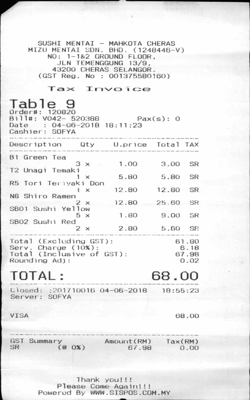

In [12]:
import random

random_sample = random.randint(0, len(dataset))

print(f"Random sample is {random_sample}")
print(f"OCR text is {dataset[random_sample]['text']}")
dataset[random_sample]['image'].resize((250,400))


## 3. Preprocess and upload dataset for Donut

As we learned in the introduction, Donut is a sequence-to-sequence model with a vision encoder and text decoder. When fine-tuning the model we want it to generate the `"text"` based on the image we pass it. Similar to NLP tasks, we have to tokenize and preprocess the text. 
Before we can tokenize the text, we need to transform the JSON string into a Donut compatible document. 

**current JSON string**
```json
{"company": "ADVANCO COMPANY", "date": "17/01/2018", "address": "NO 1&3, JALAN WANGSA DELIMA 12, WANGSA LINK, WANGSA MAJU, 53300 KUALA LUMPUR", "total": "7.00"}
```

**Donut document**
```json
<s></s><s_company>ADVANCO COMPANY</s_company><s_date>17/01/2018</s_date><s_address>NO 1&3, JALAN WANGSA DELIMA 12, WANGSA LINK, WANGSA MAJU, 53300 KUALA LUMPUR</s_address><s_total>7.00</s_total></s>
```

To easily create those documents the ClovaAI team has created a [json2token](https://github.com/clovaai/donut/blob/master/donut/model.py#L497) method, which we extract and then apply.

In [13]:
new_special_tokens = [] # new tokens which will be added to the tokenizer
task_start_token = "<s>"  # start of task token
eos_token = "</s>" # eos token of tokenizer

def json2token(obj, update_special_tokens_for_json_key: bool = True, sort_json_key: bool = True):
    """
    Convert an ordered JSON object into a token sequence
    """
    if type(obj) == dict:
        if len(obj) == 1 and "text_sequence" in obj:
            return obj["text_sequence"]
        else:
            output = ""
            if sort_json_key:
                keys = sorted(obj.keys(), reverse=True)
            else:
                keys = obj.keys()
            for k in keys:
                if update_special_tokens_for_json_key:
                    new_special_tokens.append(fr"<s_{k}>") if fr"<s_{k}>" not in new_special_tokens else None
                    new_special_tokens.append(fr"</s_{k}>") if fr"</s_{k}>" not in new_special_tokens else None
                output += (
                    fr"<s_{k}>"
                    + json2token(obj[k], update_special_tokens_for_json_key, sort_json_key)
                    + fr"</s_{k}>"
                )
            return output
    elif type(obj) == list:
        return r"<sep/>".join(
            [json2token(item, update_special_tokens_for_json_key, sort_json_key) for item in obj]
        )
    else:
        # excluded special tokens for now
        obj = str(obj)
        if f"<{obj}/>" in new_special_tokens:
            obj = f"<{obj}/>"  # for categorical special tokens
        return obj


def preprocess_documents_for_donut(sample):
    # create Donut-style input
    text = json.loads(sample["text"])
    d_doc = task_start_token + json2token(text) + eos_token
    # convert all images to RGB
    image = sample["image"].convert('RGB')
    return {"image": image, "text": d_doc}

proc_dataset = dataset.map(preprocess_documents_for_donut)

print(f"Sample: {proc_dataset[45]['text']}")
print(f"New special tokens: {new_special_tokens + [task_start_token] + [eos_token]}")


  0%|          | 0/626 [00:00<?, ?ex/s]

Sample: <s><s_total>$6.90</s_total><s_date>27 MAR 2018</s_date><s_company>UNIHAKKA INTERNATIONAL SDN BHD</s_company><s_address>12, JALAN TAMPOI 7/4,KAWASAN PARINDUSTRIAN TAMPOI,81200 JOHOR BAHRU,JOHOR</s_address></s>
New special tokens: ['<s_total>', '</s_total>', '<s_date>', '</s_date>', '<s_company>', '</s_company>', '<s_address>', '</s_address>', '<s>', '</s>']


The next step is to tokenize our text and encode the images into tensors. Therefore we need to load `DonutProcessor`, add our new special tokens and adjust the size of the images when processing from `[1920, 2560]` to `[720, 960]` to need less memory and have faster training.

In [14]:
from transformers import DonutProcessor

# Load processor
model_id = "naver-clova-ix/donut-base"
processor = DonutProcessor.from_pretrained(model_id)

# add new special tokens to tokenizer
processor.tokenizer.add_special_tokens({"additional_special_tokens": new_special_tokens + [task_start_token] + [eos_token]})

# we update some settings which differ from pretraining; namely the size of the images + no rotation required
# resizing the image to smaller sizes from [1920, 2560] to [960,1280]
processor.feature_extractor.size = [720,960] # should be (width, height)
processor.feature_extractor.do_align_long_axis = False

2023-05-17 20:00:59.772688: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-17 20:00:59.873049: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-17 20:00:59.875997: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-17 20:00:59.876008: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

Now, we can prepare our dataset, which we will use for the training later.


In [15]:
def transform_and_tokenize(sample, processor=processor, split="train", max_length=512, ignore_id=-100):
    # create tensor from image
    try:
        pixel_values = processor(
            sample["image"], random_padding=split == "train", return_tensors="pt"
        ).pixel_values.squeeze()
    except Exception as e:
        print(sample)
        print(f"Error: {e}")
        return {}
        
    # tokenize document
    input_ids = processor.tokenizer(
        sample["text"],
        add_special_tokens=False,
        max_length=max_length,
        padding="max_length",
        truncation=True,
        return_tensors="pt",
    )["input_ids"].squeeze(0)

    labels = input_ids.clone()
    labels[labels == processor.tokenizer.pad_token_id] = ignore_id  # model doesn't need to predict pad token
    return {"pixel_values": pixel_values, "labels": labels, "target_sequence": sample["text"]}

# need at least 32-64GB of RAM to run this
processed_dataset = proc_dataset.map(transform_and_tokenize,remove_columns=["image","text"])

  0%|          | 0/626 [00:00<?, ?ex/s]

Before we can upload our dataset to S3 for training we want to split the dataset into train and test sets.

In [16]:
processed_dataset = processed_dataset.train_test_split(test_size=0.1)
print(processed_dataset)

DatasetDict({
    train: Dataset({
        features: ['pixel_values', 'labels', 'target_sequence'],
        num_rows: 563
    })
    test: Dataset({
        features: ['pixel_values', 'labels', 'target_sequence'],
        num_rows: 63
    })
})


After that is done we use the new [FileSystem integration](https://huggingface.co/docs/datasets/filesystems) to upload our dataset to S3. We are using the `sess.default_bucket()`, adjust this if you want to store the dataset in a different S3 bucket. We will use the S3 path later in our training script.

In [11]:

# save train_dataset to s3
training_input_path = f's3://{sess.default_bucket()}/processed/donut-sagemaker/train'
processed_dataset["train"].save_to_disk(training_input_path)

# save train_dataset to s3
training_input_path = f's3://{sess.default_bucket()}/processed/donut-sagemaker/test'
processed_dataset["test"].save_to_disk(training_input_path)

print("uploaded data to:")
print(f"training dataset to: {training_input_path}")

Flattening the indices:   0%|          | 0/1 [00:00<?, ?ba/s]

Saving the dataset (0/10 shards):   0%|          | 0/563 [00:00<?, ? examples/s]

Loading cached processed dataset at /home/ubuntu/.cache/huggingface/datasets/imagefolder/default-a22cf722aa030b1d/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f/cache-fe194f9f3899e99b.arrow


Saving the dataset (0/10 shards):   0%|          | 0/563 [00:00<?, ? examples/s]

uploaded data to:
training dataset to: s3://sagemaker-us-east-1-558105141721/processed/donut-sagemaker/test


## 4. Fine-tune and evaluate Donut model on Amazon SageMaker

After we have processed our dataset, we can start training our model using a Amazon SageMaker training job using the `HuggingFace` Estimator. The Estimator handles end-to-end Amazon SageMaker training and deployment tasks. The Estimator manages the infrastructure use. 
SagMaker takes care of starting and managing all the required ec2 instances for us, provides the correct huggingface container, uploads the provided scripts and downloads the data from our S3 bucket into the container at `/opt/ml/input/data`. Then, it starts the training job by running.

_Important steps we need to think of is that we extended the `DonutProcessor` earlier and added special tokens, which we need to pass through to our training script. We also need to pass the `image_size` and `max_length` to our training script._ 


As pretrained model we will use [naver-clova-ix/donut-base](https://huggingface.co/naver-clova-ix/donut-base). The `donut-base` includes only the pre-trained weights and was introduced in the paper [OCR-free Document Understanding Transformer](https://arxiv.org/abs/2111.15664) by Geewok et al. and first released in [this repository](https://github.com/clovaai/donut).

In addition to loading our model, we are resizing the `embedding` layer to match newly added tokens and adjusting the `image_size` of our encoder to match our dataset. We are also adding tokens for inference later.

In [118]:
import time
import json
from sagemaker.huggingface import HuggingFace

# define Training Job Name 
job_name = f'huggingface-donut-{time.strftime("%Y-%m-%d-%H-%M-%S", time.localtime())}'

# stingify special tokens
special_tokens = ",".join(processor.tokenizer.special_tokens_map_extended["additional_special_tokens"])

# hyperparameters, which are passed into the training job
hyperparameters = {
  'model_id': model_id,                                # pre-trained model
  'special_tokens': json.dumps(special_tokens),        # special tokens which will be added to the tokenizer
  'dataset_path': '/opt/ml/input/data/training',       # path where sagemaker will save training dataset
  'epochs': 1,                                         # number of training epochs
  'per_device_train_batch_size': 8,                    # batch size for training
  'gradient_checkpointing': True,                    # batch size for training
  'lr': 4e-5,                                          # learning rate used during training
}

# create the Estimator
huggingface_estimator = HuggingFace(
    entry_point          = 'train.py',        # train script
    source_dir           = 'scripts',         # directory which includes all the files needed for training
    instance_type        = 'ml.g5.2xlarge',   # instances type used for the training job
    instance_count       = 1,                 # the number of instances used for training
    base_job_name        = job_name,          # the name of the training job
    role                 = role,              # Iam role used in training job to access AWS ressources, e.g. S3
    volume_size          = 100,               # the size of the EBS volume in GB
    transformers_version = '4.26',            # the transformers version used in the training job
    pytorch_version      = '1.13',            # the pytorch_version version used in the training job
    py_version           = 'py39',            # the python version used in the training job
    hyperparameters      =  hyperparameters
)

In [119]:
# define a data input dictonary with our uploaded s3 uris
data = {'training': training_input_path}

# starting the train job with our uploaded datasets as input
huggingface_estimator.fit(data, wait=True)

Using provided s3_resource


INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: huggingface-donut-2023-05-17-19-14-42-2023-05-17-19-14-44-283


2023-05-17 19:14:45 Starting - Starting the training job.........
2023-05-17 19:15:59 Starting - Preparing the instances for training......
2023-05-17 19:17:03 Downloading - Downloading input data......
2023-05-17 19:17:53 Training - Downloading the training image.........
2023-05-17 19:19:43 Training - Training image download completed. Training in progress....bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-05-17 19:20:12,523 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-05-17 19:20:12,537 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2023-05-17 19:20:12,547 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-05-17 19:20:12,548 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-05-17 19:20:12,754 sagemaker-training-toolkit INFO     No Neurons detected (n

: 

## 5. Deploy Donut model on Amazon SageMaker

During the training we copied a `infernece.py` into out `model.tar.gz` which allows us now to easily deploy our model to SageMaker for inference. 
The [inference.py](./scripts/inference.py) implements a custom `model_fn` and `predict_fn` for our Donut model. The `model_fn` loads the model and processor and the `predict_fn` tokenizes the input and returns the prediction. 


In [114]:
from sagemaker.huggingface import HuggingFaceModel

# create Hugging Face Model Class
huggingface_model = HuggingFaceModel(
   model_data=huggingface_estimator.model_data,
   # model_data=""
   role=role, 
   transformers_version="4.26", 
   pytorch_version="1.13", 
   py_version="py39",
   model_server_workers=1
)

Before we can deploy model with the `HuggingFaceModel` class we need to create a new serializer, which supports our image data. The Serializer are used in Predictor and in the `predict` method to serializer our data to a specific `mime-type`. The default serialzier for the `HuggingFacePredcitor` is a `JSON` serializer, but since we are not going to send text data to the endpoint we will use the DataSerializer.



In [115]:
from sagemaker.serializers import DataSerializer

# create a serializer for the data
image_serializer = DataSerializer(content_type='image/x-image') # using x-image to support multiple image formats

# deploy model to SageMaker Inference
predictor = huggingface_model.deploy(
   initial_instance_count=1,
   instance_type= "ml.g5.4xlarge",
   serializer=image_serializer, # serializer for our image files.
)

INFO:sagemaker:Creating model with name: huggingface-pytorch-inference-2023-05-17-16-24-56-058
INFO:sagemaker:Creating endpoint-config with name huggingface-pytorch-inference-2023-05-17-16-24-56-982
INFO:sagemaker:Creating endpoint with name huggingface-pytorch-inference-2023-05-17-16-24-56-982


----------!

In [1]:
huggingface_model

NameError: name 'huggingface_model' is not defined

SageMaker starts the deployment process by creating a SageMaker Endpoint Configuration and a SageMaker Endpoint. The Endpoint Configuration defines the model and the instance type.

Lets test by using a example from the `test` split.

In [23]:
from PIL import Image
import io
from random import randrange
from transformers.image_transforms import to_pil_image
import numpy as np 
test_sample = processed_dataset["test"][randrange(0,len(processed_dataset["test"]))]

image = to_pil_image(np.array(test_sample["pixel_values"])).resize((350,600))


def image_to_byte_array(image: Image) -> bytes:
  # BytesIO is a file-like buffer stored in memory
  img_byte_arr = io.BytesIO()
  # image.save expects a file-like as a argument
  image.save(img_byte_arr, format=image.format)
  # Turn the BytesIO object back into a bytes object
  return img_byte_arr.getvalue()


In [117]:
  
res = predictor.predict(data=image_to_byte_array(image))

print(f"Reference:\n {test_sample['target_sequence']}")
print(f"Prediction:\n {res}")
image

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /tmp/ipykernel_46093/200735041.py:2 in <module>                                                  │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_46093/200735041.py'                         │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
ImportError: cannot import name 'np' from 'numpy' 
(/home/ubuntu/miniconda3/envs/dev/lib/python3.9/site-packages/numpy/__init__.py)

Awesome!! Our fine-tuned model parsed the document correctly and extracted the right values. The next step is to evalute our model on the test set. Since the model itself is a seq2seq is not that straightforward to evaluate. 

To keep things simple we will use `rogue` short for Recall-Oriented Understudy for Gisting Evaluation. This metric does not behave like the standard accuracy: it will compare a generated text against a set of reference text. The rogue score is mostly used for summarization or machine translation tasks. 

In [ ]:
!pip install rouge-score py7zr

In [ ]:
import evaluate
from tqdm import tqdm

# Metric
rogue = evaluate.load("rouge")

predictions, references = [], []
# iterate over dataset
for sample in tqdm(processed_dataset["test"]):
  reference = sample["target_sequence"]
  image = sample["pixel_values"].unsqueeze(0)
  prediction = predictor.predict(data=image)
  
  predictions.append(json.dumps(prediction))
  references.append(json.dumps(reference))
  
# compute scores
results = rogue.compute(predictions=predictions,references=references)
print(results)

Our model achieves an accuracy of `75%` on the test set. 

_Note: The evaluation we did was very simple and only valued exact string matches as "truthy" for each key of the dictonary, is a big bias for the evaluation. Meaning that a accuracy of `75%` is pretty good._

Our first inference test is an excellent example of why this metric is biased. There the model predicted for the `address` the value `NO. 31G&33G, JALAN SETIA INDAH X ,U13/X 40170 SETIA ALAM` and the ground truth was `'NO. 31G&33G, JALAN SETIA INDAH X,U13/X 40170 SETIA ALAM'`, where the only difference is the ` ` whitespace in between `X` and `,U13/X`. 
In our evaluation loop, this was not counted as a truthy value.
